In [667]:
# Packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim
using StaticArrays

# Importing the necessary python libraries
@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

<h1>Downloading and processing data</h1>

For now, just working with one neutrino distribution model at a time.

The model has multiple components, but we only care about a few for now.

<h2>Spatial distribution</h2>

We are given $N$ neutrinos, each with their own position in $3D$ space. We thus have the following:
$$
\mathrm{Dist}(\vec{x}) = \delta^3(\vec{x} - \vec{x}_{\nu_1}) + \delta^3(\vec{x} - \vec{x}_{\nu_2}) + \dots + \delta^3(\vec{x} - \vec{x}_{\nu_N}).
$$

However, this isn't very helpful to us: in practice, we aren't going to be able to distinguish individual point neutrino sources. So we want to turn this discrete distribution into some continuous probability density distribution, $P_{\nu_e + \nu_{\mu}}(\vec{x})$.

We thus histogram over 3D spatial bins and count the number of neutrinos in each bin, then divide by the bin volume and the total number of neutrinos.


In [1266]:
# Getting the model-dependent neutrino distribution

model_2 = readdlm("second_GC_model.txt", comments=true)
numv = size(model_2)[1]


# Histogramming and interpolating the distribution

bsize = 0.3
xbins, ybins, zbins = -30:bsize:30, -30:bsize:30, -3:bsize:3
nubins= fit(Histogram, (vec(model_2[:, 24]), vec(model_2[:, 25]), vec(model_2[:, 26])), (xbins, ybins, zbins), closed=:left)

binvals = nubins.weights ./ (numv*bsize^3)
xedges = collect(xbins)
yedges = collect(ybins)
zedges = collect(zbins)
pop!(xedges)
pop!(yedges)
pop!(zedges)
pds = interpolate((xedges, yedges, zedges), binvals, Gridded(Linear()))
probdens = extrapolate(pds, 0.0)

200×200×20 extrapolate(interpolate((::Vector{Float64},::Vector{Float64},::Vector{Float64}), ::Array{Float64, 3}, Gridded(Linear())), 0.0) with element type Float64:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  … 

In [1264]:
pdsext(100, 0, 0)

0.0

In [128]:
# Testing out binning angularly from the beginning

function galr(x, y, z)
    r = sqrt((8-x)^2 + y^2 + z^2)
end

function gall(x, y, z)
    l = atan(y / (8-x))
end

function galb(x, y, z)
    r = sqrt((8-x)^2 + y^2 + z^2)
    b = asin(z/r)
end

rpos = galr.(vec(model_2[:, 24]), vec(model_2[:, 25]), vec(model_2[:, 26]))
lpos = gall.(vec(model_2[:, 24]), vec(model_2[:, 25]), vec(model_2[:, 26]))
bpos = galb.(vec(model_2[:, 24]), vec(model_2[:, 25]), vec(model_2[:, 26]))

angbins = fit(Histogram, (rpos, lpos, bpos), (0:0.1:30, (-pi):0.01:(pi), (-pi/2):0.01:(pi/2)), closed=:left)

angweights = angbins.weights ./ (numv * 0.01^2)

300×628×314 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  

In [3]:
# Downloading and interpolating the effective area data

eff_a = readdlm("EffA_GC_approx.csv", ',')
itp = interpolate((eff_a[:, 1],), eff_a[:, 2], Gridded(Linear())) # in m^2
effarea = extrapolate(itp, fill(0))

31-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), fill(0)) with element type Any:
   0.05232991146814947
   0.09646616199111992
   0.1539926526059492
   0.25482967479793467
   0.3924189758484536
   0.6042963902381329
   0.8976871324473142
   1.2863969449369745
   1.715437896342879
   2.371373705661655
   3.0505278902670256
   3.9241897584845358
   5.0480657166674705
   ⋮
  26.416483203860924
  31.622776601683793
  36.51741272548377
  42.169650342858226
  50.4806571666747
  60.42963902381328
  69.78305848598663
  83.53625469578262
  93.0572040929699
 107.46078283213174
 115.47819846894582
 143.30125702369628

<h2>Energy distribution</h2>

Currently, the models we have aren't fine-tuned enough for us to care about their own energy distributions. We thus assume independence of energy and spatial distribution and inject our own energy distribution in the form of a power law. This is consistent with the $\pi^0$ model used in the Galactic plane paper.
$$
\Phi_{\nu_{e} + \nu_{\mu}} \sim E^{-\gamma}
$$
for some spectral index $\gamma$.

So far all of this is unitless. We add units to our flux with the normalization factor $\Phi_0$. We're given the flux normalization factor in units of $E^2 \frac{dN}{dE}$, or differential per-flavor counts of neutrinos ($N_{\nu}$) multiplied by energy squared, at $E = 100~\mathrm{TeV}$. This is given in units of $10^{-12}~\mathrm{TeV}~\mathrm{cm}^{-2}~\mathrm{s}^{-1}$, or specifically $21.8 \times 10^{-12}~\mathrm{TeV}~\mathrm{cm}^{-2}~\mathrm{s}^{-1}$.

What does this mean? Well, it means that at $100$ TeV, we expect the neutrino energy density to be $21.8 \times 10^{-16}~\mathrm{TeV}^{-1}~\mathrm{cm}^{-2}~\mathrm{s}^{-1}$. 

<h2>Event distributions (null case)</h2>

This means that by accounting for the spatial weights from the above model and the effective area of our detector, we can derive an expression for the total number of events expected in energy bin $[E_0, E_1]$ from spatial bin $S$:
$$
N_{\nu} \in [E_0, E_1] \times S = \int_S d^3\vec{x}~P_{\nu}(\vec{x})~\int_{E_0}^{E_1} dE_{\nu}~\Phi_0 \left(\frac{E_{\nu}}{E_0}\right)^{-\gamma} A_{\mathrm{eff}}(E_{\nu}).
$$

<h2>Pseudo-Dirac oscillations</h2>

We now need to take into account the possibility for pseudo-Dirac oscillations. The probability that a neutrino in the flavor state $\alpha$ oscillates into flavor state $\beta$ can be described by the following expression:
$$
O_{\alpha \to \beta} = \sum_j |U_{\alpha j}|^2 |U_{\beta j}|^2 \cos^2\left(\frac{\delta m_j^2 L_{\mathrm{eff}}}{4E_{\nu}}\right),
$$
where $U_{ij}$ are values of the PMNS matrix, $\delta m_i^2$ is the pseudo-Dirac mass-splitting value between active and sterile versions of mass state $i$, and $L_{\mathrm{eff}}$ is the distance the neutrino has propagated in space.

We now can write an expression for the expected number of neutrinos coming from angular bin $A = (l, b, \Theta)$, where $\Theta$ is the width of the bin in radians:
$$
N_{\nu} \in [E_0, E_1] \times A = \int_0^{\infty}dr~\int_{A}d\vec{\theta}~P_{\nu}(r, \vec{\theta})\int_{E_0}^{E_1} dE_{\nu}~\Phi_0 \left(\frac{E_{\nu}}{E_0}\right)^{-\gamma} A_{\mathrm{eff}}(E_{\nu})O_{(e,~\mu) \to e}(E_{\nu}).
$$

In [1018]:
# Core functions defs

emin = 0.7916819159263001
emax = 791.6819159263017


# Functions that return areas of square latitude-longitude bins on a sphere's surface

function spherebinareas(r)
    ϕs = range(0, 2π, length=50)
    θs = range(-π/2, π/2, length=25)

    Δϕ = ϕs[2] - ϕs[1]
    sinθs = sin.(θs)

    bin = zeros(length(ϕs)-1, length(θs)-1)

    for i in 1:length(ϕs)-1
        for j in 1:length(θs)-1
            bin[i, j] = r^2 * Δϕ * (sin(θs[j+1]) - sin(θs[j]))
        end
    end

    return bin
end

# Want function that returns the area on a sphere of radius r for an angular bin centered at angle (l, b) with size θ
function sbinarea(r, l, b, θ)

    Δl = θ

    Δsinb = abs(sin(b+(θ/2)) - sin(b-(θ/2)))

    area = r^2 * Δl * Δsinb

end

function sbinareas1(r, bsize)


    bedges = (-π/2):bsize:(π/2)
    ledges = 0:bsize:(2π)

    bbins = collect((-π/2 + bsize/2):bsize:(π/2 - bsize/2))
    lbins = collect((0 + bsize/2):bsize:(2π - bsize/2))

    bin = zeros(length(lbins), length(bbins))

    for (i, l) in enumerate(lbins)
        for (j, b) in enumerate(bbins)
            bin[i, j] = sbinarea(r, l, b, bsize)
        end
    end

    return bin
end


# Flux calculation functions 

function oscprob(et, dm2, leff)

    # Norms for the PMNS matrix squared:
    # uₑ = [0.674743, 0.302844, 0.0224125]
    # uₘ = [0.0946105, 0.360415, 0.544974]
    # uₜ = [0.230646, 0.33674,  0.432613]
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    osc = (cos((dm2 * leff)/(4*et*1e12)))^2
    # osc2 = (cos((dm2 * leff)/(4*et*1e12)))^2
    # osc3 = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_surv = osc*((u[1]*u[1]) + (u[4]*u[4]) + (u[7]*u[7]))
    prob_mue = osc*((u[1]*u[2]) + (u[4]*u[5]) + (u[7]*u[8]))
    prob_e = 0.666666*prob_mue + 0.333333*prob_surv 
end

function flux(et, x, y, z, γ)
    ϕ₀ = 21.8e-16 * 3.156e8 # TeV^-1 cm^-2
    e0 = 100.0 # TeV
    as = ϕ₀ * (et/e0)^(-γ)
    flx = probdens(x, y, z) * as
end

function flx(et, x, y, z, ϕ₀, γ, e0)
    flx = probdens(x, y, z) * ϕ₀ * (et/e0)^(-γ) * 1e-16 * 3.156e8
end

function cartesian(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    y = r*sin(l)*cos(b)
    z = r*sin(b)
    return [x, y, z]
end

function cartx(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    return x
end

function carty(r, l, b)
    y = r*sin(l)*cos(b)
    return y
end

function cartz(r, l, b)
    z = r*sin(b)
    return z
end


cartz (generic function with 1 method)

In [1341]:
# Function that calculates weight integral along logebins
function weighteventint()
    function weightint(et, l, b, θ)
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        γ = 2.7
        ϕ₀ = 21.8e-16 * 3.156e8
        e0 = 100

        vols = blength .* sbinarea.(rbins, l, b, θ)

        pds = probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b))

        flux = ϕ₀ * (et/e0)^(-γ) * effarea(et) * 10000

        return flux * sum(vols .* pds)
    end

    nsteps = 500
    es = range(emin, emax, nsteps)
    de = es[2] - es[1]

    bsize = π/100

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors

    truebins = []
    for e in es
        skybins = []
        for l in l_range
            for b in b_range
                push!(skybins, weightint(e, l, (-b), bsize))
            end
        end
        push!(truebins, sum(skybins))
    end

    int = truebins .* de
    return sum(int)
end




weighteventint (generic function with 1 method)

In [1342]:
int = weighteventint()

875.0147683016614

<h2>Energy smearing</h2>

IceCube isn't a perfect detector, unfortunately: for each event, we don't know for certain what the event's real energy and direction were. We can make an educated guess (and these educated guesses are getting better and better with more tech and research advances) and return some reconstructed energy and angle, but these aren't going to be perfect.

Let's quantify this error: for cascade events, the probability that, given some true energy $E_t$, IceCube reconstructs the energy $E_r$, is given by the following PDF (we now work in $\log_{10}$ energy, so $u_i = \log_{10} E_i$):
$$
G(u_r | u_t,~\sigma) = \ln(10)~10^{u_r - u_t}~N(\mathrm{abs}\left(1 - 10^{u_r - u_t}\right)|0,~\sigma),
$$
with $N$ being the normal distribution with standard deviation $\sigma$.

We can convolve this with our energy dependent functions in log energy space to accurately smear the energy distribution.

In [502]:
function smearedeventdist(dm2, l, b, σ, γ, θ, nsteps)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        flx = flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), γ) .* blength .* (pi .* (rbins .* tan(θ)) .^ 2)
        probe = oscprob.(et, dm2, rbins)
        effa = effarea(et)[1]*10000

        sum(.*(flx, probe, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges) ./ 2
end

function edistbinned(dm2, l, b, σ, γ, θ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdist(dm2, l, b, σ, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

edistbinned (generic function with 1 method)

<h2>The Likelihood Ratio Test</h2>

How do we test how well hypothetical data is able to distinguish between two hypotheses? We use a likelihood ratio test!

To calculate the likelihood that data $k$ match a hypothesis $\lambda$, we assume a Poisson distribution and use the poisson likelihood:
$$
\mathrm{Poisson}(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}.
$$
This likelihood is bin-dependent: to determine the likelihood over $n$ energy bins, we get
$$
\mathrm{Poisson}(k_1, k_2, \dots, k_n | \lambda) = \prod_{i=1}^{n} \mathrm{Poisson}(k_i|\lambda).
$$
To simplify calculations, we know that the maximum of a function is achieved at the maximum of the log of the function. We thus get
$$
\log \mathrm{Poisson}(k_1, k_2, \dots, k_n | \lambda) = \sum_{i=1}^{n} \log \mathrm{Poisson}(k_i|\lambda).
$$
To determine the relative "goodness" of a null and alternative hypothesis (in this case, null is the Standard Model and alt is any pseudo-Dirac scenario), we take the ratio (or, for log likelihood, the difference) of the likelihood of the data given the null vs. likelihood of the data given the alt. Multiplying by $-2$ for convention, we achieve our test statistic:
$$
TS = -2~\sum_{i=1}^{n} ( \log \mathrm{Poisson}(k_1, \dots, k_n | \mathrm{null}) - \log \mathrm{Poisson}(k_1, \dots, k_n | \mathrm{alt})).
$$
Assuming a $\chi^2$ distribution, we can convert this test statistic into a $\sigma$ significance value.

<h2>Maximizing Likelihood</h2>

We want to remove the systematic errors of the parameters $\Phi_0$ and $\gamma$ in the flux model, and to do so we maximize the likelihood of any nonzero $\delta m^2$ value over these parameters. For each $\{\Phi_0, \gamma\}$ pair, we calculate expected null data $k$. We then find expected results for a given PD hypothesis $\lambda$, compute the following,
$$
\mathrm{MaxLH}(\delta m^2) = \max_{\Phi_0, \gamma} \mathrm{Poisson}(\{k(\Phi_0, \gamma)\} | \lambda(\delta m^2, \Phi_0, \gamma)),
$$
and determine the pair $\{ \hat{\Phi_0}, \hat{\gamma} \}$ that results in this maximum.

This is basically saying that this parameter pair will result in the closest our alternative hypothesis could be to our sample null data.

In [1346]:
# Varying ϕ₀, γ:

function fluxfreeparams(et, x, y, z, ϕ₀, γ)
    pds = probdens.(x, y, z)
    e0 = 100.0 # TeV
    as = ϕ₀ * (et/e0)^(-γ) * 3.156e-8 * 3 # The three is because the flux normalization is per-flavor
    pds * as
end

function smearedeventdistfreeparams(dm2, l, b, σ, ϕ₀, γ, θ, nsteps)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
        vols = blength .* sbinarea.(rbins, l, b, θ) .* oscprob.(et, dm2, rbins)

        flx = fluxfreeparams(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        effa = effarea(et)[1]*10000

        sum(.*(flx, vols, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges)
end

function edistbinnedfreeparams(dm2, l, b, σ, θ, ϕ₀, γ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdistfreeparams(dm2, l, b, σ, ϕ₀, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end


# Likelihood functions

function poissonlog(data, hyp)
    val = log((hyp^data) * exp(-hyp) / gamma(data+1))
end


function negloglh(dm2, l, b, θ, ϕ₀, γ)

    # σ = 0.5
    nullhyp = edistbinnedfreeparams(0, l, b, 0.5, θ, 21.8, 2.7)
    althyp = edistbinnedfreeparams(dm2, l, b, 0.5, θ, ϕ₀, γ)

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end

function maxlh(dm2, l, b, θ)

    function nllh(test)
        return negloglh(dm2, l, b, θ, test[1], test[2])
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

function lrt(null, alt)
    altsummand = sum(poissonlog.(null, alt) .- poissonlog.(null, null))
    ts = -2 * altsummand
end

lrt (generic function with 1 method)

In [1228]:
# Testing interior functions

function wtf(l, b)

    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
        vols = blength .* sbinarea.(rbins, l, b, θ) .* oscprob.(et, dm2, rbins)

        flx = fluxfreeparams(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
        effa = effarea(et)[1]*10000

        sum(.*(flx, vols, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)

    fsample = f.(samples)

end

# wtf(0, 0.1)

function f(ur, l, b)
    et = 10^ur
    r0, rmax = 0, 30
    blength = 2
    rbins = range(r0, stop=rmax, step=blength)

    # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
    # vols = blength .* sbinarea.(rbins, l, b, θ) .* oscprob.(et, dm2, rbins)
    xs = cartx.(rbins, l, b)
    flx = fluxfreeparams(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), 21.8, 2.7)
    # effa = effarea(et)[1] .* 10000

    # thing = flx .* vols
    
end

f(0, 0, 0.1)
# x = -21.850124958340775
# y = 0
# z = 2.9950024994048445
# fluxfreeparams(1, x, y, z, 21.8, 2.7)
# fluxfreeparams(1, 100, 0, 0, 21.8, 2.7)

0.0005064318078577107

In [966]:
# Testing interior of smeared event dist function (free params)

# function smearedeventdistfreeparams(dm2, l, b, σ, ϕ₀, γ, θ, nsteps)
dm2 = 0; l = 0; b = 0; σ = 0.5; ϕ₀ = 21.8; γ = 2.7; θ = 0.122; nsteps = 2
    
function f(ur)
    et = 10^ur
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)

    # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
    vols = blength .* sbinarea.(rbins, l, b, θ) .* oscprob.(et, dm2, rbins)

    flx = zeros(length(rbins))
    for i in 1:length(rbins)
        flx[i] = fluxfreeparams(et, cartx(rbins[i], l, b), carty(rbins[i], l, b), cartz(rbins[i], l, b), ϕ₀, γ)
    end
    # flx = fluxfreeparams.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
    effa = effarea(et)[1]*10000

    sum(.*(flx, vols, effa))
end

samples = range(-0.5, log10(emax)+0.5, length=300)
de = samples[2]-samples[1]

pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
gsample = pdf_func.(samples)
g_fft = fft(gsample)

fsample = f.(samples)

300-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [549]:
# Plotting likelihoods for different parameter values

ϕrange = range(18, 22, length=40)
γrange = range(2, 4, length=40)

grid = Iterators.product(ϕrange, γrange)
lhvals = [negloglh(10^(-14), 0, 0, 0.122, ϕ₀, γ) for (ϕ₀, γ) in grid]
# lhmat = reshape(lhvals, length(ϕrange), length(γrange))

loglhvals = log10.(lhvals)

hmap = heatmap(
    γrange, 
    ϕrange, 
    loglhvals, 
    γlims=(2, 4), 
    ϕlims=(18, 22), 
    title=L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2",
    ylabel=L"\Phi_0",
    xlabel=L"\gamma",
    colorbar_title=L"\log(-\log(\mathrm{LH}))"
)
# scatter!(hmap, [21.8], [2.7], marker=:x, markersize=5, color=:red, label=L"\pi^0~\mathrm{model}")

40×40 Matrix{Float64}:
 59.9261  57.5896  55.268   52.9646  …  353.967  439.58   546.078  678.525
 59.842   57.5062  55.1854  52.883      356.085  442.201  549.32   682.537
 59.7584  57.4233  55.1033  52.8019     358.203  444.822  552.564  686.551
 59.6754  57.341   55.0218  52.7214     360.322  447.444  555.808  690.564
 59.593   57.2592  54.9409  52.6414     362.441  450.066  559.052  694.579
 59.511   57.178   54.8605  52.562   …  364.561  452.689  562.297  698.593
 59.4296  57.0973  54.7806  52.483      366.681  455.312  565.542  702.609
 59.3488  57.0171  54.7012  52.4046     368.802  457.936  568.788  706.625
 59.2684  56.9375  54.6224  52.3268     370.924  460.561  572.035  710.641
 59.1886  56.8583  54.5441  52.2494     373.046  463.186  575.282  714.658
 59.1093  56.7797  54.4663  52.1726  …  375.168  465.811  578.529  718.675
 59.0305  56.7016  54.389   52.0962     377.291  468.437  581.777  722.693
 58.9521  56.6239  54.3122  52.0204     379.415  471.064  585.026  726.712
  

In [595]:
# Testing different interior functions

dm2 = 0
l = 0
b = 0
γ = 2.7

function f(ur, θ)
    et = 10^ur
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)

    vols = blength .* (π .* (rbins .* tan(θ)) .^ 2)
    # vols = blength .* sbinarea.(rbins, l, b, θ)

    flx = similar(vols)

    flx .= flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), γ) .* vols .* oscprob.(et, dm2, rbins) .* (effarea(et)[1]*10000)
    # probe .= flx 
    # effa .= probe .* 

    # sum(.*(flx, probe, effa))
end

function f1(ur, θ)
    et = 10^ur
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)
    # vols = blength .* (pi .* (rbins .* tan(θ)) .^ 2)
    vols = blength .* sbinarea.(rbins, l, b, θ)

    flx = flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), γ) .* vols
    probe = oscprob.(et, dm2, rbins)
    effa = effarea(et)[1]*10000

    sum(.*(flx, probe, effa))
end

f1 (generic function with 1 method)

In [274]:
# More testing

blength = 0.5
θ = 0.07
r0, rmax = 0, 30
blength = 0.5
rbins = range(r0, stop=rmax, step=blength)

vols = blength .* (2 .* rbins .* tan(θ)) .^ 2
vols1 = blength .* sbinarea.(rbins, l, b, 2*θ)
vols ./ vols1

61-element Vector{Float64}:
 NaN
   1.0040955708272492
   1.0040955708272492
   1.004095570827249
   1.0040955708272492
   1.004095570827249
   1.004095570827249
   1.0040955708272492
   1.0040955708272492
   1.0040955708272492
   1.004095570827249
   1.004095570827249
   1.004095570827249
   ⋮
   1.0040955708272492
   1.004095570827249
   1.004095570827249
   1.004095570827249
   1.004095570827249
   1.0040955708272492
   1.0040955708272492
   1.0040955708272492
   1.004095570827249
   1.004095570827249
   1.0040955708272492
   1.0040955708272492

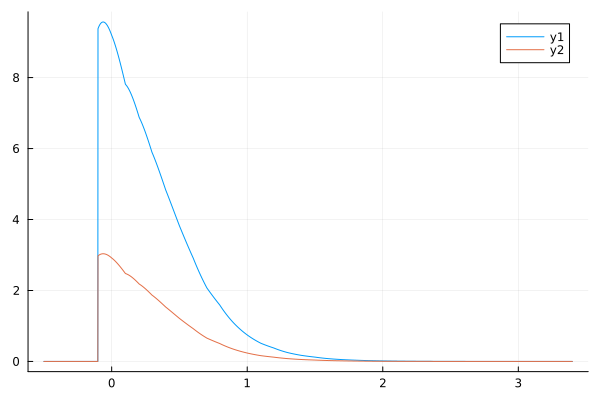

In [212]:
# Plotting the two different binning strategies

sample = range(-0.5, log10(emax)+0.5, length=3000)

plot(
    sample,
    [f.(sample, 0.07) f1.(sample, 0.07)]
)

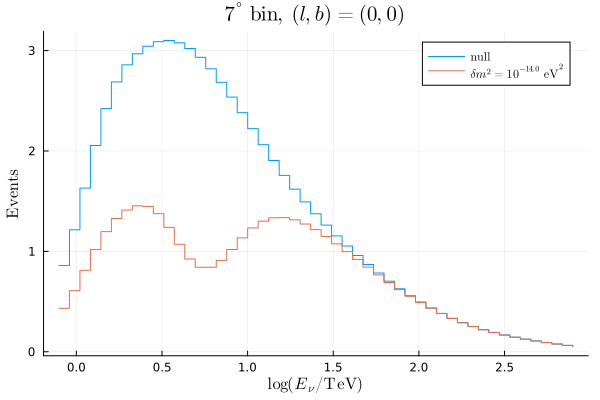

In [1146]:
# Plotting null and alt hypotheses

sample = range(log10(emin), log10(emax), length=50)
plot(sample, 
    [edistbinnedfreeparams(0, 0, 0, 0.5, 0.244, 21.8, 2.7) edistbinnedfreeparams(10^(-14.0), 0, 0, 0.5, 0.244, 21.8, 2.7)],
    seriestype=:step,
    xlabel=L"\log (E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"],
    title=L"7^{\circ}~\mathrm{bin},~(l, b) = (0, 0)"
)

In [293]:
# Functions that just compute all-sky events

function allsky(dm2, ϕ₀, γ, bsize)

    bbins = 0:bsize:pi
    lbins = 0:bsize:(2*pi)

    # Going to be a vector of vectors
    skybins = []

    for l in lbins
        for b in bbins
            push!(skybins, edistbinnedfreeparams(dm2, l, b, 0.5, bsize, ϕ₀, γ))
        end
    end

    ebins = zeros(50)

    for ebin in 1:50
        ebins[ebin] = sum([skybins[skybin][ebin] for skybin in 1:length(skybins)])
    end

    return sum(ebins)

end

# New function
function allsky2(dm2, ϕ₀, γ, bsize)

    bbins = (-π/2+bsize):bsize:(π/2-bsize)
    lbins = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = []

    for l in lbins
        for b in bbins
            push!(skybins, edistbinnedfreeparams(dm2, l, b, 0.5, bsize, ϕ₀, γ))
        end
    end

    # ebins = zeros(50)

    # for ebin in 1:50
    #     ebins[ebin] = sum([skybins[skybin][ebin] for skybin in 1:length(skybins)])
    # end
    sum(sum(skybins))

end


allsky2 (generic function with 1 method)

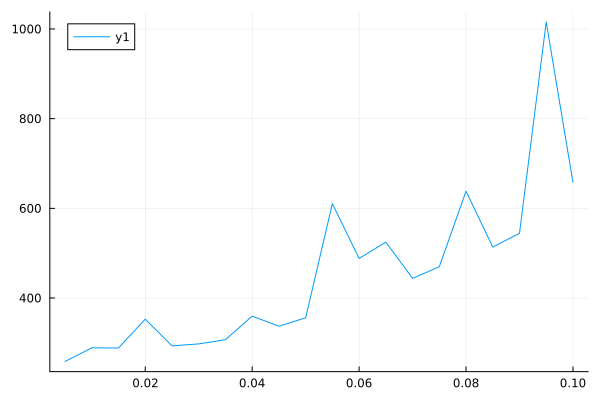

In [112]:
# Testing the current all sky function 

plot(bsizes, allskyevents)
bsizes2 = 0.105:0.005:0.2
allskyevents2 = [allsky.(0, 21.8, 2.7, bsize2) for bsize2 in bsizes2]

bsizestot = 0.005:0.005:0.2
akes = vcat(allskyevents, allskyevents2)
plot(
    bsizestot, 
    akes,
    label=false,
    title="All-sky events",
    xlabel="Angular bin size (cone)",
    ylabel="Events / 10 yrs"
    )

In [494]:
# Testing interior of some all sky functions

dm2 = 0; ϕ₀ = 21.8; γ = 2.7

bsize = π/4

b_range = (-π/2+bsize):bsize:(π/2-bsize)
l_range = (0+bsize/2):bsize:(2π-bsize/2)

# Going to be a vector of vectors
skybins = []

for l in l_range
    for b in b_range
        push!(skybins, edistbinnedfreeparams(dm2, l, -b, 0.5, bsize, ϕ₀, γ))
    end
end

# Convert the list of function values to a 2D array
edistvals = reshape(skybins, length(b_range), length(l_range))
edistvals1 = edistvals'

# Now the data are split into all-sky maps for each energy bin
matrix = zeros(length(l_range), length(b_range))
ebins = [copy(matrix) for _ in 1:50]
for i in 1:50
    for j in 1:length(l_range)
        for k in 1:length(b_range)
            ebins[i][j, k] = edistvals1[j, k][i]
        end
    end
end

ebins

50-element Vector{Matrix{Float64}}:
 [5.186142142134076e-5 7.46701053788114 0.00023497297729067846; 4.985343692800734e-5 1.2953479664521539 0.00021248941024109826; … ; 3.790871538011459e-5 1.3827606478823624 0.00019978393340201804; 5.567872367999398e-5 7.406217330172579 0.00025247641134801095]
 [7.327679609299836e-5 10.550397455620697 0.00033200144678658213; 7.043964535082167e-5 1.8302419448946265 0.00030023363724757503; … ; 5.35625351354736e-5 1.9537503458901275 0.00028228162956853956; 7.867039448591806e-5 10.464500629752628 0.0003567326541695449]
 [9.830603124621225e-5 14.15410822023247 0.0004454035430283772; 9.449979183098643e-5 2.4553996819756048 0.0004027847681408688; … ; 7.185794867411421e-5 2.621094982190751 0.0003787008736214123; 0.00010554192692416952 14.038871521878185 0.00047858221588766166]
 [0.00012391883844628843 17.84184172282767 0.0005614496790507409; 0.0001191209154582069 3.0951333570749413 0.0005077269418685561; … ; 9.057993105761087e-5 3.3039991700711417 0.0004773681

In [312]:
# Converting from angles to the appropriate pixels in the Healpix scheme

nside = 150
npix = hp.nside2npix(nside)
thedges = (bsize):bsize:(π-bsize)
phedges = (0+bsize/2):bsize:(2π-bsize/2)
theta, phi = np.meshgrid(thedges, phedges)
pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

7080-element Vector{Int64}:
    181
    181
    145
    182
    182
    146
    183
    183
    147
    184
    184
    148
    185
      ⋮
 269853
 269817
 269817
 269854
 269818
 269818
 269855
 269819
 269819
 269856
 269820
 269820

In [506]:
# Calculating the number of total events after smearing

bins = [dist(i) for i in 1:50]
sum(sum(bins))

LoadError: BoundsError: attempt to access 8×3 Matrix{Float64} at index [9, 1]

<h2>Angular smearing</h2>

IceCube also has pretty bad angular resolution for cascade events of around $7^{\circ}$. To implement this, we use the healpy Python package and call the smoothing function.

<h2> All-sky Maximum Likelihood</h2>

When computing the maximum likelihood over the whole sky, we need to consider every angular bin. It should be noted, however, that the bins with the most events (near the GC) will contribute the most to this maximization.

In [1358]:
# All sky smearing and binning functions

function dist(index)

    # bin = reshape(ebins[index], 45, 90)
    bin = ebins[index]
    e = []
    
    for (j, thval) in enumerate(thedges)
        for (i, phval) in enumerate(phedges)
                push!(e, bin[i, j])
        end
    end

    E = np.zeros(hp.nside2npix(nside))

    # E[pixel_indices] = e
    
    for (i, eval) in enumerate(e)
        E[pixel_indices[i]] = eval
    end
    
    E_smoothing = hp.smoothing(E, fwhm=np.radians(7.))

    twod_array = hp.cartview(E_smoothing, return_projected_map=true) 
end

# Binning into angular bins
# For this 400x800 matrix, each pixel represents a 0.007854 radian^2 angular bin, so 16 pixels is 7.2 degrees
function bin7ish(index)
    ebin = dist(index)

    bsize_l = 16
    bsize_b = 16

    nbins_l = convert(Int, (size(ebin, 1)/bsize_l))
    nbins_b = convert(Int, (size(ebin, 2)/bsize_b))

    binned_mat = reshape(ebin, bsize_l, nbins_l, bsize_b, nbins_b)

    bins = sum(binned_mat, dims=(1, 3))

    binned_sums = reshape(bins, nbins_l, nbins_b)
end

# res in number of bins: each bin is 0.00785 radians, 400/res must be an integer
function anglesmearbin(dm2, ϕ₀, γ, res)

    bsize = π/60

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = []

    for l in l_range
        for b in b_range
            push!(skybins, edistbinnedfreeparams(dm2, l, (-b), 0.5, bsize, ϕ₀, γ))
        end
    end

    # Convert the list of function values to a 2D array
    edistvals = reshape(skybins, length(b_range), length(l_range))
    edistvals1 = edistvals'

    # Now the data are split into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:50]
    for i in 1:50
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 150
    npix = hp.nside2npix(nside)
    thedges = (bsize):bsize:(π-bsize)
    phedges = (0+bsize/2):bsize:(2π-bsize/2)
    theta, phi = np.meshgrid(thedges, phedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    function dist(index)

        # bin = reshape(ebins[index], 45, 90)
        bin = ebins[index]
        e = []
        
        for (j, thval) in enumerate(thedges)
            for (i, phval) in enumerate(phedges)
                    push!(e, bin[i, j])
            end
        end
    
        E = np.zeros(hp.nside2npix(nside))
    
        # E[pixel_indices] = e
        
        for (i, eval) in enumerate(e)
            E[pixel_indices[i]] = eval
        end
        
        E_smoothing = hp.smoothing(E, fwhm=np.radians(7.))
    
        twod_array = hp.cartview(E_smoothing, return_projected_map=true) 
    end

    # res in number of bins: each bin is 0.00785 radians, 400/res must be an integer
    nbins = convert(Int, 400/res)
    
    function anglebin(index, res)

        ebin = dist(index)
    
        bsize_l = res
        bsize_b = res
    
        nbins_l = convert(Int, (size(ebin, 1)/bsize_l))
        nbins_b = convert(Int, (size(ebin, 2)/bsize_b))
    
        binned_mat = reshape(ebin, bsize_l, nbins_l, bsize_b, nbins_b)
    
        bins = sum(binned_mat, dims=(1, 3))
    
        binned_sums = reshape(bins, nbins_l, nbins_b)
    end

    allsky_ebins = [anglebin(ebin, res) for ebin in 1:50]

    allskyedists = [zeros(50) for _ in 1:nbins, _ in 1:(2*nbins)]

    for i in 1:nbins
        for j in 1:(2*nbins)
            allskyedists[i, j] = [allsky_ebins[k][i, j] for k in 1:50]
        end
    end

    return allskyedists

end

# Approximate negloglh all sky function
function allskynllh(dm2, ϕ₀, γ)

    sumllh = 0

    for lval in (-pi/2):0.122:(pi/2)
        for bval in (-0.122):0.122:(0.122)
            sumllh += negloglh(dm2, lval, bval, 0.122, ϕ₀, γ)
        end
    end
    
    return sumllh
end

function allskymaxlh(dm2)

    function nllh(test)
        return allskynllh(dm2, test[1], test[2])
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

allskymaxlh (generic function with 1 method)

In [1352]:
function getdist(dm2, ϕ₀, γ)   
    bsize = π/100

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = []

    for l in l_range
        for b in b_range
            push!(skybins, edistbinnedfreeparams(dm2, l, (-b), 0.5, bsize, ϕ₀, γ))
        end
    end
    return skybins
end


getdist (generic function with 1 method)

In [1353]:
events = getdist(0, 21.8, 2.7)

19600-element Vector{Any}:
 [4.259656330442617e-9, 6.01861576095659e-9, 8.074400910004826e-9, 1.0178117957091309e-8, 1.1999303620456816e-8, 1.3315442271745541e-8, 1.415688330302957e-8, 1.4702763238978023e-8, 1.5076892984338062e-8, 1.5300759815404894e-8  …  1.0880006907988906e-9, 9.492596839228808e-10, 8.269748573531485e-10, 7.181550894539745e-10, 6.208599488335337e-10, 5.335165984659032e-10, 4.5459114905196746e-10, 3.824758670898323e-10, 3.1589993051430737e-10, 2.537757063237787e-10]
 [8.406235883450196e-9, 1.1877461432010648e-8, 1.5934458886262457e-8, 2.0086047737095112e-8, 2.3680073894650732e-8, 2.6277412998979223e-8, 2.7937958179686835e-8, 2.9015227130430704e-8, 2.975355497815752e-8, 3.019534587452139e-8  …  2.1471193304608203e-9, 1.8733203335387497e-9, 1.6319968516969294e-9, 1.4172460439369065e-9, 1.2252385581394373e-9, 1.0528704727628444e-9, 8.97114727812811e-10, 7.547985351556539e-10, 6.234139858866857e-10, 5.008146862933809e-10]
 [1.2493431528462969e-8, 1.765240152550663e-8, 2.3

In [1355]:
sum(sum(events))

646.677003976841

In [365]:
# Testing out getting binned sensitivities

test = allskymaxlh(10^(-13.5))
params = Optim.minimizer(test)

testarray = anglesmearbin(10^(-13.5), params[1], params[2], 16) 
nullarray = anglesmearbin(0, 21.8, 2.7, 16)

g2nullarray = nullarray .* 8
g2testarray = testarray .* 8

array = zeros(25, 50)
for i in 1:25
    for j in 1:50
        array[i, j] = lrt(nullarray[i, j], testarray[i, j])
    end
end

 * Status: success

 * Candidate solution
    Final objective value:     4.433299e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   221  (vs limit Inf)
    Iterations:    35
    f(x) calls:    72


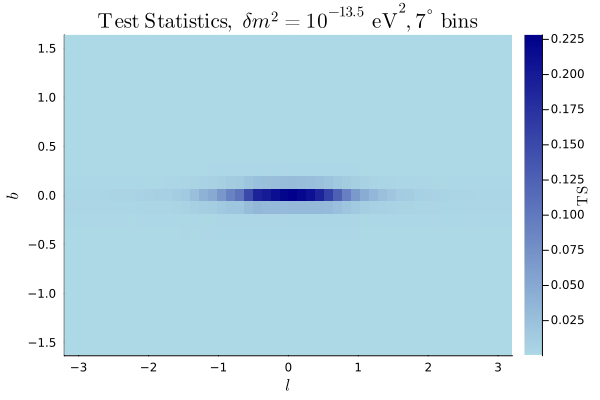

In [385]:
# Printing out the test binned sensitivities

lvals = range(-pi, pi, length=50)
bvals = range(-pi/2, pi/2, length=25)

heatmap(
    lvals,
    bvals,
    array,
    xlabel=L"l", 
    ylabel=L"b", 
    title=L"\mathrm{Test~Statistics},~\delta m^2 = 10^{-13.5}~\mathrm{eV}^2, 7^{\circ}~\mathrm{bins}",
    c=:blues,
    colorbar_title=L"\mathrm{TS}",
)

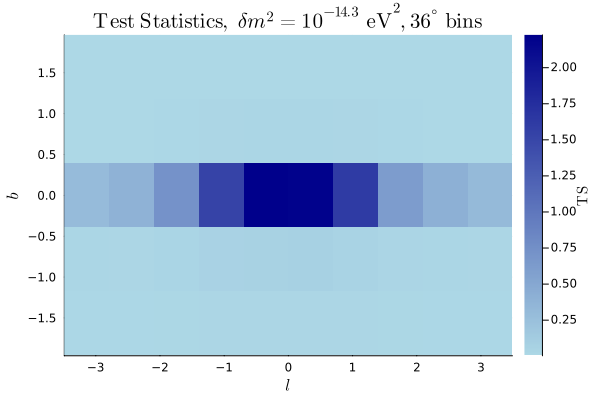

In [101]:
# Plotting rebinned sensitivities

lvals = range(-pi, pi, length=10)
bvals = range(-pi/2, pi/2, length=5)

heatmap(
    lvals,
    bvals,
    rebinned_array,
    xlabel=L"l", 
    ylabel=L"b", 
    title=L"\mathrm{Test~Statistics},~\delta m^2 = 10^{-14.3}~\mathrm{eV}^2, 36^{\circ}~\mathrm{bins}",
    c=:blues,
    colorbar_title=L"\mathrm{TS}",
)

In [401]:
# all-sky LRT function as a function of delta m^2 and the angular resolution we want

function lhratio(dm2, res)

    # We first find the maximum-likelihood parameters:
    opt = allskymaxlh(dm2)
    optparams = Optim.minimizer(opt)

    nullarray = anglesmearbin(0, 21.8, 2.7, res)
    testarray = anglesmearbin(dm2, optparams[1], optparams[2], res)

    nbins = convert(Int, 400/res)
    
    array = zeros(nbins, 2*nbins)
    for i in 1:nbins
        for j in 1:(2*nbins)
            array[i, j] = lrt(nullarray[i, j], testarray[i, j])
        end
    end

    return array
end


lhratio (generic function with 1 method)

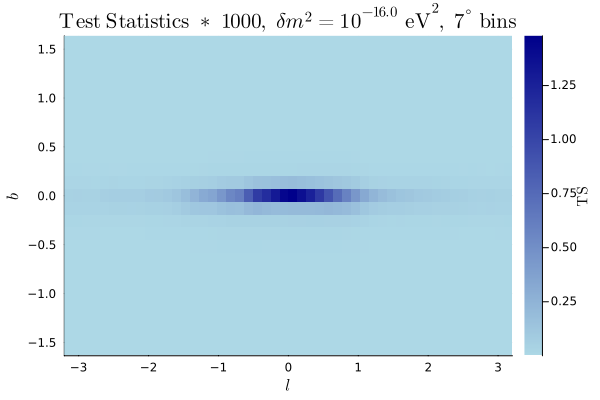

In [1359]:
# Plotting the lhratio function

testlh = lhratio(10^(-14.3), 16)



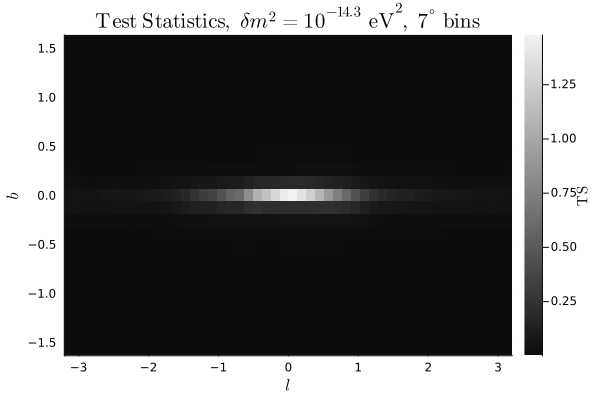

In [1363]:
lvals = range(-pi, pi, length=50)
bvals = range(-pi/2, pi/2, length=25)

heatmap(
    lvals,
    bvals,
    testlh,
    xlabel=L"l", 
    ylabel=L"b", 
    title=L"\mathrm{Test~Statistics},~\delta m^2 = 10^{-14.3}~\mathrm{eV}^2,~7^{\circ}~\mathrm{bins}",
    c=:grays,
    colorbar_title=L"\mathrm{TS}",
)

In [456]:
# Sampling all sky sensitivities for different dm2 vals

logdmsample = range(-15, -12, length=31)
dmsample = 10 .^ logdmsample
teststats = [lhratio.(dm2, 16) for dm2 in dmsample]

31-element Vector{Matrix{Float64}}:
 [3.5412999713736875e-6 3.592112736459459e-6 … 3.594008435215098e-6 3.542708362269396e-6; 1.496545536324126e-7 1.4953402751351678e-7 … 1.55944479389734e-7 1.5172815512135645e-7; … ; 7.743927481621497e-8 7.686977242175326e-8 … 7.730649615678743e-8 7.75779760754169e-8; 3.320998277676413e-6 3.3675505483057327e-6 … 3.3707784337607796e-6 3.322766336651573e-6]
 [8.572622873025986e-6 8.696020052547557e-6 … 8.700719217188113e-6 8.576185020465004e-6; 3.6909797758659695e-7 3.6877214112131505e-7 … 3.8472168842792084e-7 3.742575192136718e-7; … ; 1.876480928295363e-7 1.861478465721908e-7 … 1.8723061233249957e-7 1.8799175818787498e-7; 7.99415441729028e-6 8.106263456060048e-6 … 8.114483744042914e-6 7.998666072275243e-6]
 [2.0043239293027526e-5 2.0333441546050414e-5 … 2.0344604741172005e-5 2.0052025091253145e-5; 8.975633193648522e-7 8.966821748001386e-7 … 9.359095066200541e-7 9.102541807967884e-7; … ; 4.4427443600656677e-7 4.402683682859044e-7 … 4.4292354526087344e-

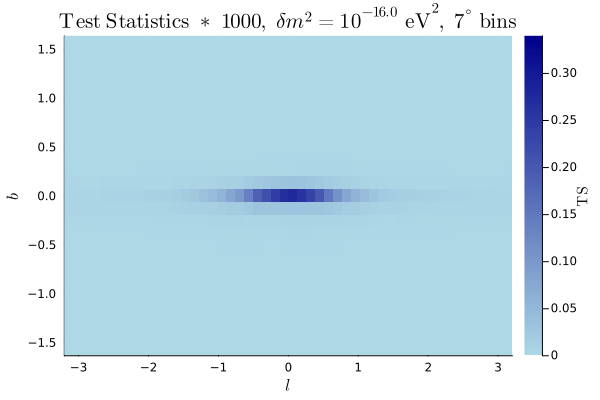

In [479]:
# Plotting a single frame of the above vector

lvals = range(-pi, pi, length=50)
bvals = range(-pi/2, pi/2, length=25)

heatmap(
    lvals,
    bvals,
    teststats[10],
    xlabel=L"l", 
    ylabel=L"b", 
    title=L"\mathrm{Test~Statistics~*~1000},~\delta m^2 = 10^{-16.0}~\mathrm{eV}^2,~7^{\circ}~\mathrm{bins}",
    c=:blues,
    clims=(0, 0.34),
    colorbar_title=L"\mathrm{TS}",
)

[ Info: Saved animation to /Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/test_allsky_sensitivities_7degbins.gif


Plots.AnimatedGif("/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/test_allsky_sensitivities_7degbins.gif")
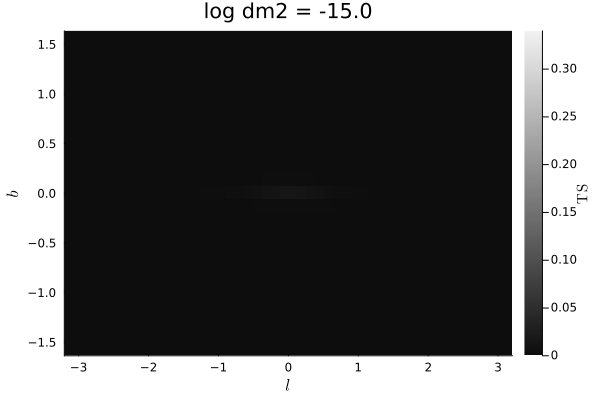

In [488]:
# GIF making

logdms = range(-15, -12, length=31)
veclogdms = collect(logdms)
vecdms = 10 .^ veclogdms

# These lengths are dependent on the angular bin size
lvals = range(-pi, pi, length=50)
bvals = range(-pi/2, pi/2, length=25)

anim = @animate for dm2 in 1:31
    teststat = teststats[dm2]
    logdm2 = veclogdms[dm2]
    hm_binned = heatmap(
        lvals, 
        bvals, 
        teststat, 
        xlabel=L"l", 
        ylabel=L"b", 
        title="log dm2 = $logdm2",
        c=:grays,
        colorbar_title=L"\textrm{TS}",
        clims=(0, 0.34),
        )
    frame_delay = 50
end

gif(anim, "test_allsky_sensitivities_7degbins.gif", fps=2)